For this lab, you are going to take the data you had been working on in the previous two labs and plot them!

Here is the schema of the trip dataset, found in `trip_data_500k.csv`:

* `medallion`: The ID of the cab being operated
* `hack_license`: The ID of the person operating the cab
* `vendor_id`: The type of vendor operating the cab, can either be `CMT` or `VTS`, no clue what these two types mean
* `rate_code`: Designates the kind of ride this is, must be `1` through `6`, any other number is incorrect
* `store_and_fwd_flag`: Can be either `Y`,`N`, or Nan
* `pickup_datetime`: The time when the ride started
* `dropoff_datetime`: The time when the ride ended
* `passenger_count`: The number of passengers during the ride
* `trip_time_in_secs`: How long the trip took
* `trip_distance`: Distance of the trip, to the nearest 1/10 mile
* `pickup_longitude`: Longitude of pickup location
* `pickup_latitude`: Latitude of pickup location
* `dropoff_longitude`: Longitude of dropoff location
* `dropoff_latitude`: Latitude of dropoff location

And here is the schema for the fare dataset, found in `trip_fare_500k.csv`:

* `medallion`: The ID of the cab being operated
* `hack_license`: The ID of the person operating the cab
* `vendor_id`: The type of vendor operating the cab, can either be `CMT` or `VTS`, no clue what these two types mean
* `pickup_datetime`: The time when the ride started
* `payment_type`: How the trip was paid, `UNK` stands for unknown, I have no idea what `NOC` stands for, but lets assume its some known way to pay
* `fare_amount`: Base fare cost of the trip
* `surcharge`: Additional charges that are not tolls
* `mta_tax`: The mta has to get its cut, right? :)
* `tip_amount`: How generous the rider(s) decided to be
* `tolls_amount`: How much money you had to pay in tolls
* `total_amount`: How much the trip cost, all in

Answer the following questions (using plots!):

1. Plot the distribution of fares paid in the dataset (histogram):
  * Across all time
  * For weekends versus weekdays - 1) stacked (overlaid) and 2) in separate graphs
* Plot the average tip paid as a function of distance:
  * As a scatter plot  - use `kind="scatter"`
  * By creating a categorical variable with 3 levels - < 2 miles, 2-5 miles, > 5 miles
* Plot the average tip amount as a function of the time of day (get the closest end time, to the closest minute, for the `dropoff_datetime`)
  * On a per-borough basis (use the dropoff location as the borough)
* Plot the overall average tip amount:
  * On a per-dropoff borough basis (bar graph), with error bars (use the standard deviation for the error)
  * On a per-pickup borough basis
* Plot the distribution of hour-of-pickup:
  * Across all time
  * For weekends and weekdays separately
* Plot the average number of passengers per ride across the whole dataset, to the closest hour (this should be a timeseries).

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

In [8]:
from geopy.distance import great_circle
queensCenter = ((40.800760+40.542920)/2,(-73.700272-73.962616)/2)
brookCenter = ((40.739877+40.57042)/2,(-73.864754-74.04344)/2)
bronxCenter = ((40.915255+40.785743)/2,(-73.765274-73.933406)/2)
manhattanCenter = ((40.874663+40.701293)/2,(-73.910759-74.018721)/2)
siCenter = ((40.651812+40.477399)/2,(-74.034547-74.259090)/2)
boroughDict = {}
boroughDict["queens"] = queensCenter
boroughDict["brooklyn"] = brookCenter
boroughDict["bronx"] = bronxCenter
boroughDict["manhattan"] = manhattanCenter
boroughDict["staten"] = siCenter

#This function returns the string representation of the likely borough, given a set of latitude/longitude coordinates
#If the distance to the borough center is too far away from the closest borough, we assume that the location
#is outside of NYC
def get_closest_borough(latitude,longitude,max_dist = 20):
    global boroughDict
    borough_distances = {borough:great_circle(boroughDict[borough],(latitude,longitude)).miles for borough in boroughDict}
    min_borough = min(borough_distances, key=borough_distances.get)
    if borough_distances[min_borough] < max_dist:
        return min_borough 
    else:
        return "outside_nyc"

In [2]:
trips = pd.read_csv("../data/nycTaxiData/trip_data_500k.csv")
fares = pd.read_csv("../data/nycTaxiData/trip_fare_500k.csv")

In [3]:
trips.pickup_datetime = pd.to_datetime(trips.pickup_datetime)
trips.dropoff_datetime = pd.to_datetime(trips.dropoff_datetime)
trips.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


In [9]:
trips["pickup_borough"] = trips.apply(\
                        lambda x:\
                                get_closest_borough(x['pickup_latitude'],
                                                    x['pickup_longitude']),
                                      axis=1)
trips["dropoff_borough"] = trips.apply(\
                        lambda x:\
                                get_closest_borough(x['dropoff_latitude'],
                                                    x['dropoff_longitude']),
                                      axis=1)

In [11]:
fares.pickup_datetime = pd.to_datetime(fares.pickup_datetime)
fares.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,2013-01-01 15:11:48,CSH,6.5,0.0,0.5,0.0,0.0,7.0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,2013-01-06 00:18:35,CSH,6.0,0.5,0.5,0.0,0.0,7.0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,2013-01-05 18:49:41,CSH,5.5,1.0,0.5,0.0,0.0,7.0
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,2013-01-07 23:54:15,CSH,5.0,0.5,0.5,0.0,0.0,6.0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,2013-01-07 23:25:03,CSH,9.5,0.5,0.5,0.0,0.0,10.5


In [12]:
trips_and_fares = trips.merge(fares,on=["medallion","hack_license","vendor_id","pickup_datetime"])
trips_and_fares.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_latitude,pickup_borough,dropoff_borough,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,...,40.751171,manhattan,manhattan,CSH,6.5,0.0,0.5,0.0,0.0,7.0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,...,40.750660,manhattan,manhattan,CSH,6.0,0.5,0.5,0.0,0.0,7.0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,...,40.726002,manhattan,manhattan,CSH,5.5,1.0,0.5,0.0,0.0,7.0
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,...,40.759388,manhattan,manhattan,CSH,5.0,0.5,0.5,0.0,0.0,6.0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,...,40.747868,manhattan,manhattan,CSH,9.5,0.5,0.5,0.0,0.0,10.5


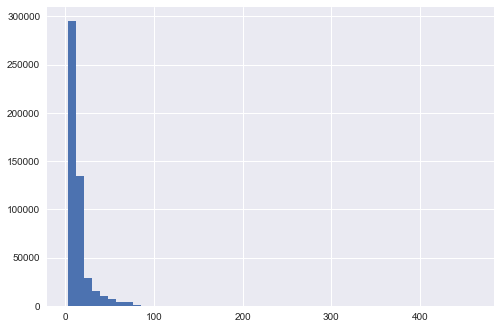

In [7]:
#1. Plot the distribution of fares paid in the dataset (histogram):
#  * Across all time
fares.total_amount.hist(bins=50)

In [8]:
trips_and_fares["is_weekend"] = np.logical_or(fares.pickup_datetime.dt.dayofweek == 0,fares.pickup_datetime.dt.dayofweek == 6)

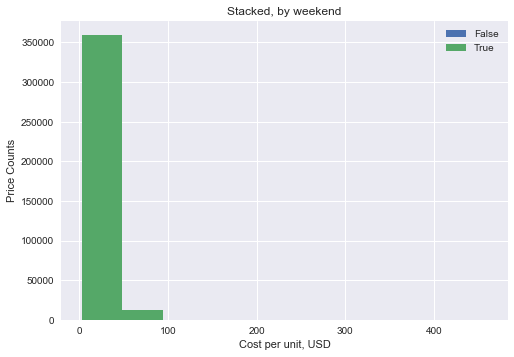

In [10]:
#  * For weekends versus weekdays - 1) stacked (overlaid) 
stackedFares = fares.total_amount.groupby(trips_and_fares.is_weekend).hist(bins=10,alpha=0.8)
sns.mpl.pyplot.xlabel("Cost per unit, USD")
sns.mpl.pyplot.ylabel("Price Counts")
sns.mpl.pyplot.legend(stackedFares.index)
sns.mpl.pyplot.title("Stacked, by weekend")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ee3c950>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10ee70e50>], dtype=object)

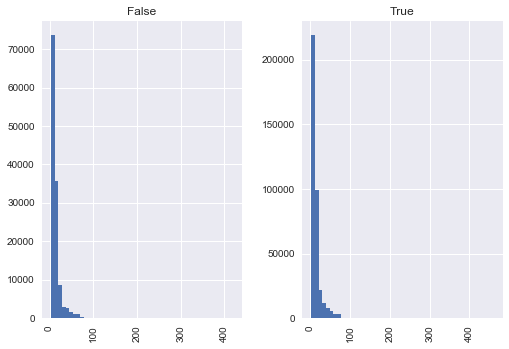

In [12]:
#and 2) in separate graphs
trips_and_fares.hist(column = "total_amount",by="is_weekend",bins=50)

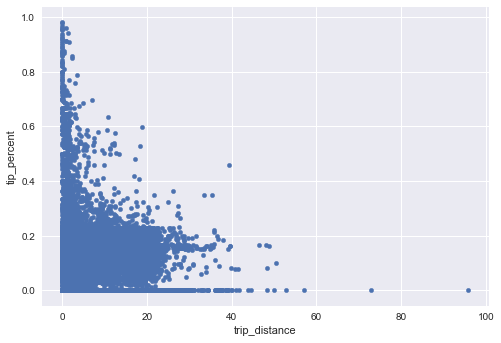

In [13]:
#* Plot the average tip paid as a function of distance:
#  * As a scatter plot  - use `kind="scatter"`
trips_and_fares["tip_percent"] = trips_and_fares.tip_amount/trips_and_fares.total_amount
trips_and_fares.plot.scatter("trip_distance","tip_percent")

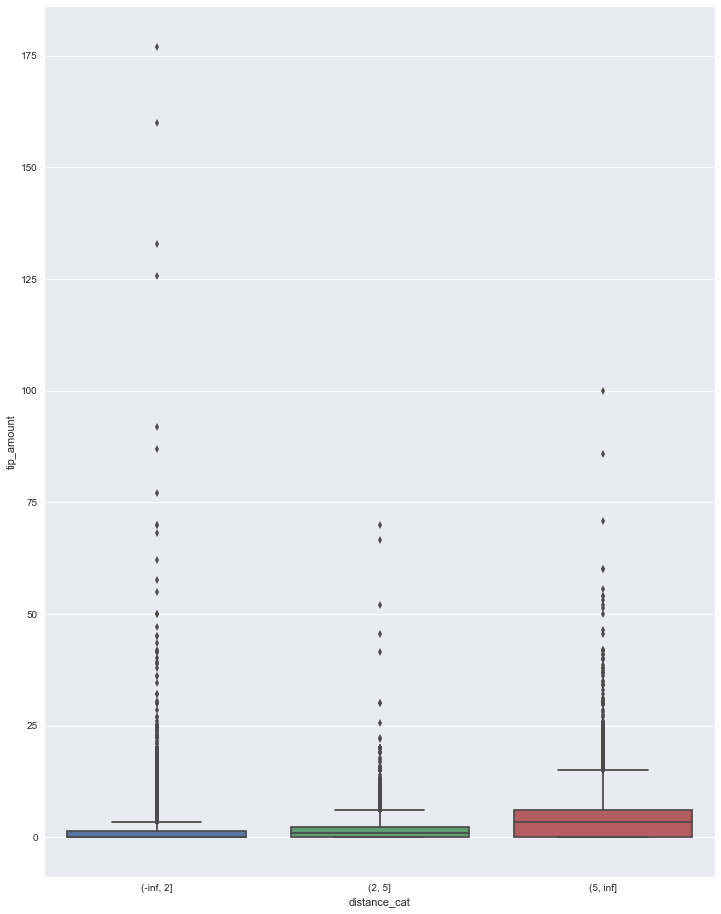

In [14]:
#  * By creating a categorical variable with 3 levels - < 2 miles, 2-5 miles, > 5 miles
trips_and_fares["distance_cat"] = pd.cut(trips_and_fares.trip_distance,[-np.inf,2,5,np.inf])
fig, ax = sns.plt.subplots(figsize=(12,16))
sns.boxplot(ax=ax, x="distance_cat", y="tip_amount", data=trips_and_fares)

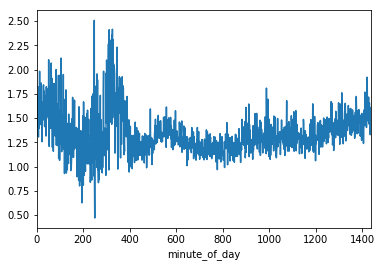

In [18]:
#* Plot the average tip amount as a function of the time of day (get the closest end time, to the closest minute, for the `dropoff_datetime`)
#  * On a per-borough basis (use the dropoff location as the borough)
trips_and_fares["minute_of_day"] = trips_and_fares.dropoff_datetime.dt.hour*60+trips_and_fares.dropoff_datetime.dt.minute
trips_and_fares.groupby("minute_of_day")["tip_amount"].mean().plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1154b52b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1183388d0>]], dtype=object)

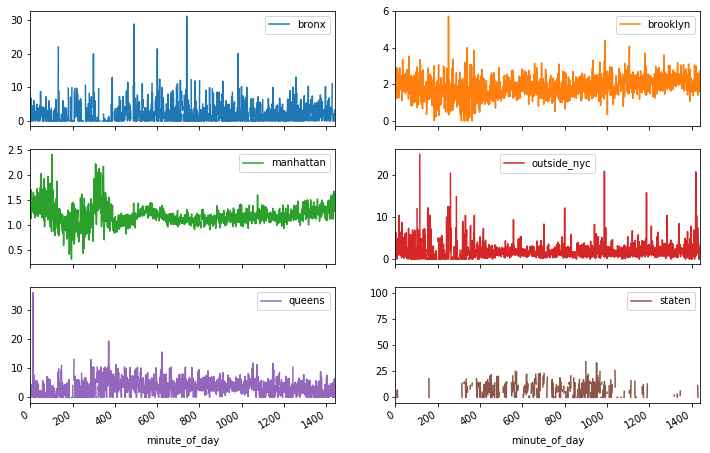

In [22]:
#  * On a per-borough basis (use the dropoff location as the borough)
per_borough_tip_means = trips_and_fares.groupby(["dropoff_borough","minute_of_day"])["tip_amount"].mean().unstack(level=0)
per_borough_tip_means.plot(subplots=True,layout=(3,2),figsize=(12,8),sharex=True,sharey=False)

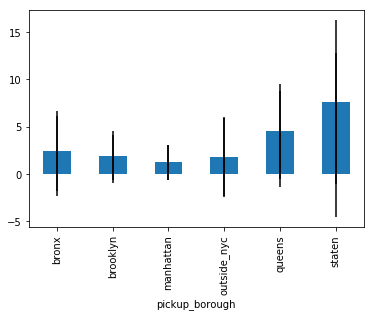

In [16]:
#* Plot the overall average tip amount:
#  * On a per-dropoff borough basis (bar graph), with error bars (use the standard deviation for the error)
dropoff_borough_tip_means = trips_and_fares.groupby("dropoff_borough").tip_amount.mean()
dropoff_borough_tip_stds = trips_and_fares.groupby("dropoff_borough").tip_amount.std()
dropoff_borough_tip_means.plot(kind="bar",yerr=per_borough_tip_stds)

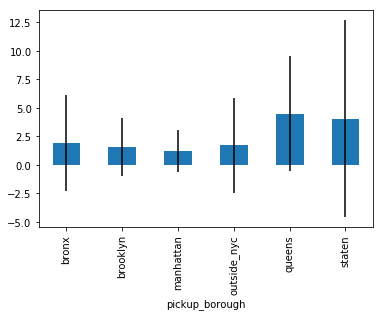

In [17]:
#  * On a per-pickup borough basis
pickup_borough_tip_means = trips_and_fares.groupby("pickup_borough").tip_amount.mean()
pickup_borough_tip_stds = trips_and_fares.groupby("pickup_borough").tip_amount.std()
pickup_borough_tip_means.plot(kind="bar",yerr=per_borough_tip_stds)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10e040790>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10e099ed0>], dtype=object)

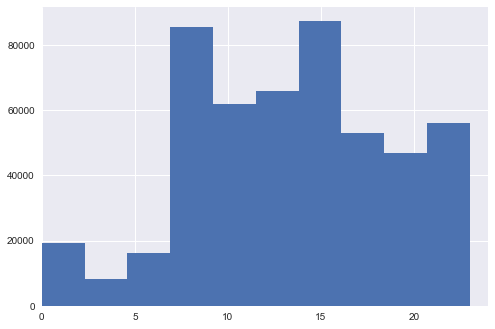

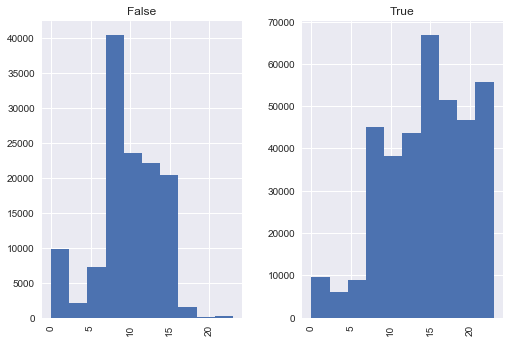

In [16]:
#* Plot the distribution of hour-of-pickup:
#  * Across all time
trips_and_fares["pickup_hour"] = trips_and_fares.pickup_datetime.dt.hour
trips_and_fares.pickup_hour.hist()
sns.mpl.pyplot.xlim(0,24)
#  * For weekends and weekdays separately
trips_and_fares.pickup_hour.hist(by=trips_and_fares.is_weekend)

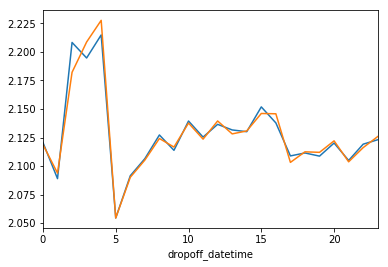

In [6]:
#Plot the average number of passengers per ride across the whole dataset, to the closest hour (this should be a timeseries).
#using pickup
trips.groupby(trips.pickup_datetime.dt.hour).passenger_count.mean().plot()
#using dropoff
trips.groupby(trips.dropoff_datetime.dt.hour).passenger_count.mean().plot()